# Background

## Context

Washington D.C. is the capital city of the USA that has a competitive housing market with fluctuating prices.

## Problem Statement

Due to the nature of a constantly changing market, individuals who want to up property for sale without going through middlemen don't have the necessary insight in the real estate industry to accurately price their homes for sale. Individual buyers also experience the same problem if they choose to not go through a real estate agent. Sellers might also be interested in any cost effective changes they can make to increase the price of their property.

## Goals

1. Provide a tool to accurately estimate the prices of houses just based on data alone
2. Determine effect of AC on price.
3. Determine effect of HEAT on price.

## Analytic Approach

The data will be analyzed to find what heating system and AC property owners are most likely to increase the value of their property. Then, we'll feed the data into a regression model that individuals can use for getting a rough price assessment without real estate knowledge.

## Metric Evaluation

RMSLE will be the metric used to evaluate the effectiveness of the ML model. It's useful in this case because property prices have a wide range so relative errors are more useful, and it penalizes underestimations more which is good as underestimations are more harmful than overestimations for real estate pricing.


In [153]:
import pandas as pd
import missingno as msn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import RobustScaler
import category_encoders as ce
from pycaret.regression import *

In [154]:
df = pd.read_csv('DC_Properties.csv')
df

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158952,158952,1,0,Forced Air,Y,NaN,3,1,1938.0,2006.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158953,158953,1,0,Forced Air,Y,NaN,4,2,1938.0,2006.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158954,158954,2,0,Forced Air,Y,NaN,4,2,1920.0,2007.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158955,158955,1,0,Warm Cool,Y,NaN,2,0,1965.0,NaN,...,-77.018230,Southwest Waterfront,NaN,11000.0,NaN,Ward 6,504,-77.018232,38.872961,SW


In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158957 entries, 0 to 158956
Data columns (total 49 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          158957 non-null  int64  
 1   BATHRM              158957 non-null  int64  
 2   HF_BATHRM           158957 non-null  int64  
 3   HEAT                158957 non-null  object 
 4   AC                  158957 non-null  object 
 5   NUM_UNITS           106696 non-null  float64
 6   ROOMS               158957 non-null  int64  
 7   BEDRM               158957 non-null  int64  
 8   AYB                 158686 non-null  float64
 9   YR_RMDL             80928 non-null   float64
 10  EYB                 158957 non-null  int64  
 11  STORIES             106652 non-null  float64
 12  SALEDATE            132187 non-null  object 
 13  PRICE               98216 non-null   float64
 14  QUALIFIED           158957 non-null  object 
 15  SALE_NUM            158957 non-nul

Float columns don't need to be floats, change them to integer

SALEDATE, GIS_LAST_MOD_DTTM converted to datetime



In [156]:
df.describe()

,Unnamed: 0,BATHRM,HF_BATHRM,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,...,USECODE,LANDAREA,CMPLX_NUM,LIVING_GBA,ZIPCODE,LATITUDE,LONGITUDE,CENSUS_TRACT,X,Y
count,158957.000000,158957.000000,158957.000000,106696.000000,158957.000000,158957.000000,158686.000000,80928.000000,158957.000000,106652.000000,...,158957.000000,158957.000000,52261.000000,52261.000000,158956.000000,158956.000000,158956.000000,158956.000000,158720.000000,158720.000000
mean,79478.000000,1.810678,0.458237,1.198039,6.187736,2.732506,1941.987579,1998.243537,1963.718024,2.091793,...,14.252999,2473.282158,2371.544249,888.834542,20012.694563,38.914854,-77.016676,5348.216324,-77.016712,38.914846
std,45887.077707,0.976396,0.587571,0.596924,2.618165,1.358864,33.640234,16.575786,24.923150,2.933323,...,3.725736,5059.046023,1114.272364,420.185822,15.627084,0.031723,0.040938,3369.645953,0.040933,0.031682
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1754.000000,20.000000,1800.000000,0.000000,...,11.000000,0.000000,1001.000000,0.000000,20001.000000,38.819731,-77.113909,100.000000,-77.113135,38.820576
25%,39739.000000,1.000000,0.000000,1.000000,4.000000,2.000000,1918.000000,1985.000000,1954.000000,2.000000,...,11.000000,697.000000,1501.000000,616.000000,20007.000000,38.895425,-77.042892,2102.000000,-77.042894,38.895432
50%,79478.000000,2.000000,0.000000,1.000000,6.000000,3.000000,1937.000000,2004.000000,1963.000000,2.000000,...,13.000000,1649.000000,2265.000000,783.000000,20011.000000,38.915337,-77.019596,5201.000000,-77.019581,38.915229
75%,119217.000000,2.000000,1.000000,1.000000,7.000000,3.000000,1960.000000,2010.000000,1975.000000,2.000000,...,17.000000,3000.000000,2910.000000,1060.000000,20018.000000,38.936075,-76.988626,8302.000000,-76.988842,38.936077
max,158956.000000,14.000000,11.000000,6.000000,48.000000,24.000000,2019.000000,2019.000000,2018.000000,826.000000,...,117.000000,942632.000000,5621.000000,8553.000000,20392.000000,38.995540,-76.909758,11100.000000,-76.910511,38.993646


In [157]:
object_columns = df.select_dtypes(include=['object']).columns

# Lists to store data for new DataFrame
columns_info = []
num_unique_values_list = []
sample_values_list = []

# Loop through object type columns in the DataFrame
for column in object_columns:
    unique_values = df[column].unique()
    num_unique_values = len(unique_values)
    sample_values = unique_values[:min(20, num_unique_values)].tolist()  # Display up to 3 unique values as examples

    columns_info.append(column)
    num_unique_values_list.append(num_unique_values)
    sample_values_list.append(sample_values)

# Create a new DataFrame to display the information
result_df = pd.DataFrame({
    'Column': columns_info,
    'Num_Unique_Values': num_unique_values_list,
    'Sample_Values': sample_values_list
})

result_df

,Column,Num_Unique_Values,Sample_Values
0,HEAT,14,"[Warm Cool, Hot Water Rad, Forced Air, Elec Ba..."
1,AC,3,"[Y, N, 0]"
2,SALEDATE,6938,"[2003-11-25 00:00:00, 2000-08-17 00:00:00, 201..."
3,QUALIFIED,2,"[Q, U]"
4,STYLE,19,"[3 Story, 4 Story, 2 Story, 2.5 Story Fin, 3.5..."
5,STRUCT,10,"[Row Inside, Semi-Detached, Single, Row End, M..."
6,GRADE,14,"[Very Good, Above Average, Good Quality, Excel..."
7,CNDTN,8,"[Good, Very Good, Average, Fair, Excellent, Po..."
8,EXTWALL,26,"[Common Brick, Brick/Stone, Stucco, Stone, Stu..."
9,ROOF,17,"[Metal- Sms, Built Up, Neopren, Comp Shingle, ..."


* CITY and STATE unnecessary, project scope is limited to D.C.
* QUADRANT EMPTY VALUES can likely be filled in through locational data of property
* CENSUS_BLOCK likely has some misspelled data, then should be turned into a numeric column
* NATIONAL GRID unlikely to be necessary for model
* GIS_LAST_MOD_DTTM should be DATETIME, same with SALEDATE
* Random 0 in AC?

In [158]:
duplicates_df = df[df.duplicated(keep=False)]

duplicates_df

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT


No duplicates found.

In [159]:
missing_values = df[df.isnull().any(axis=1)]

missing_values

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,1988.0,...,-77.040832,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,2007.0,...,-77.040764,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,...,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,2003.0,...,-77.040629,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,2012.0,...,-77.039361,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158952,158952,1,0,Forced Air,Y,NaN,3,1,1938.0,2006.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158953,158953,1,0,Forced Air,Y,NaN,4,2,1938.0,2006.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158954,158954,2,0,Forced Air,Y,NaN,4,2,1920.0,2007.0,...,-77.019420,Old City 2,040 B Old City 2,4801.0,NaN,Ward 6,477,-77.019422,38.911848,NW
158955,158955,1,0,Warm Cool,Y,NaN,2,0,1965.0,NaN,...,-77.018230,Southwest Waterfront,NaN,11000.0,NaN,Ward 6,504,-77.018232,38.872961,SW


<AxesSubplot: >

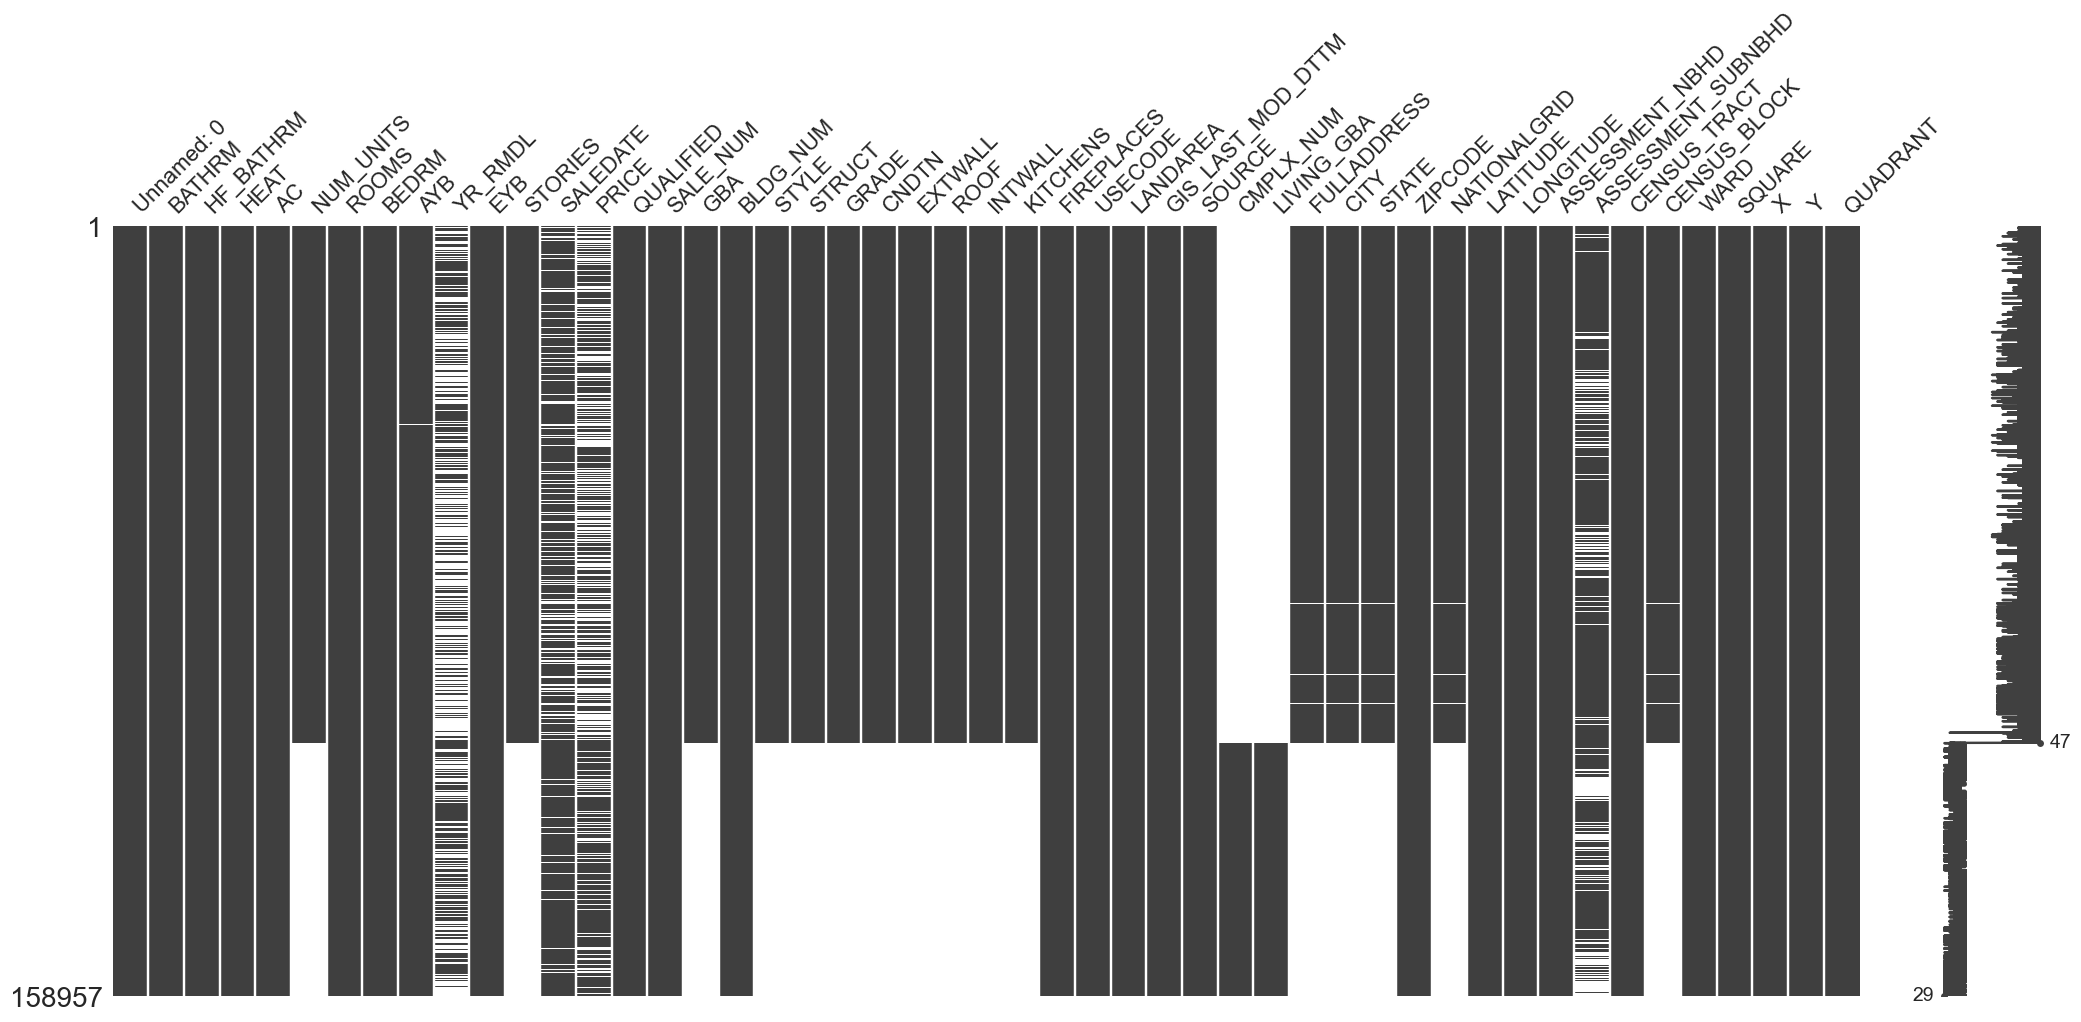

In [160]:
msn.matrix(df)

<AxesSubplot: >

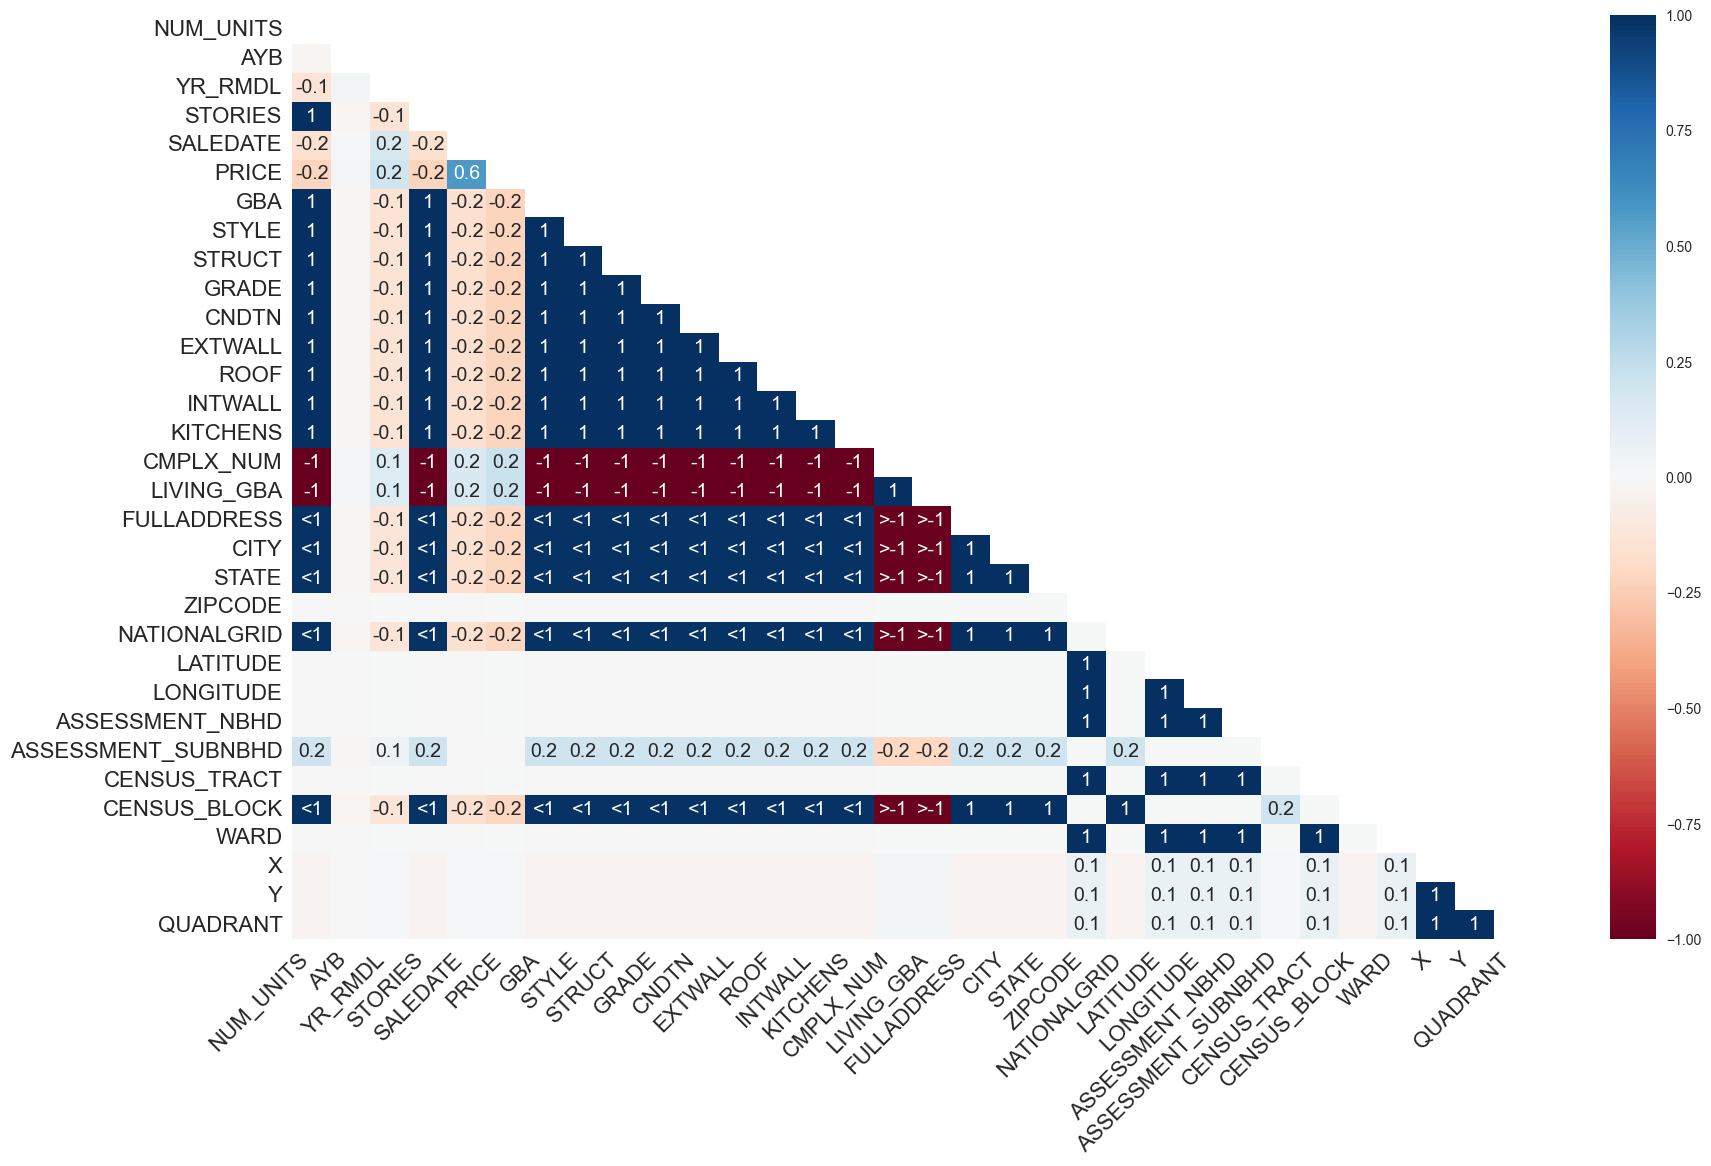

In [161]:
msn.heatmap(df)

<AxesSubplot: >

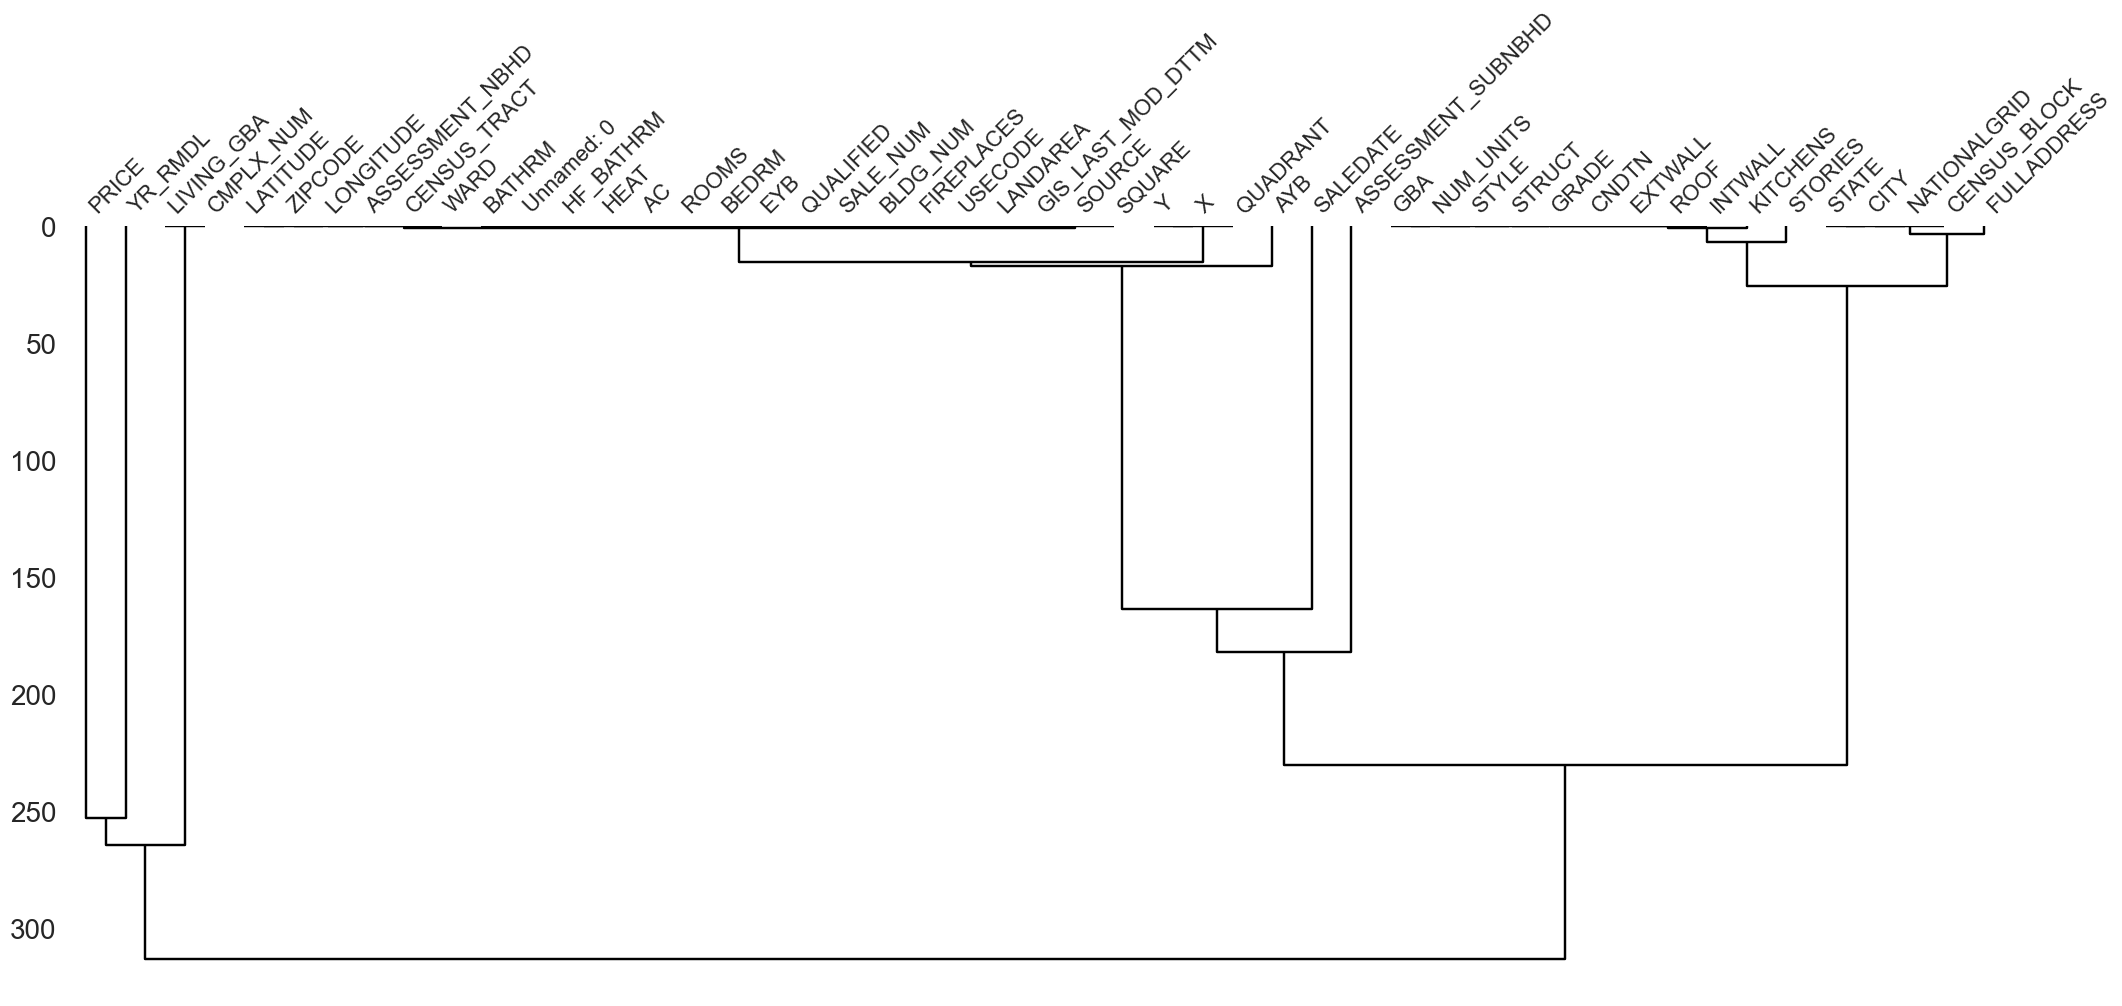

In [162]:
msn.dendrogram(df)

Lots of missing values related to the joining of the condominium and residential tables, as the condos don't include kitchens and other common residential property elements. No way to fill in these values for condominiums which can't be dropped as they are important. The condominium data will be dropped. 

The subneighborhood ID also seems to tend to be missing more in condominiums than residential properties. We'll also have to dump all data that has no price, as we need it to train our algorithm.

# Data Cleaning

Dropping columns not needed for determining price of properties or exclusive to condominium table.

Columns that don't have enough context behind it such as GRADE, EYB and YR_RMDL will be dropped as the information that can be gained from them is too limited.

X and Y will be dropped as LATITUDE and LONGITUDE are already present, along with having no missing values.

The WARD column should be converted into integers.

AC column is a boolean value, should be converted into 1 and 0.

In [163]:
df_filter = df[df['SOURCE'] == 'Residential'].copy()

df_filter.drop(labels=['SALEDATE','X','Y','EYB','CENSUS_TRACT','CENSUS_BLOCK','GRADE','ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'NATIONALGRID', 'GIS_LAST_MOD_DTTM', 'FULLADDRESS', 'YR_RMDL', 'CMPLX_NUM', 'LIVING_GBA','CITY','STATE','SOURCE','SQUARE'], axis=1, inplace=True)

df_filter

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,STORIES,...,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE,WARD,QUADRANT
0,0,4,0,Warm Cool,Y,2.0,8,4,1910.0,3.0,...,Hardwood,2.0,5,24,1680,20009.0,38.914680,-77.040832,Ward 2,NW
1,1,3,1,Warm Cool,Y,2.0,11,5,1898.0,3.0,...,Hardwood,2.0,4,24,1680,20009.0,38.914683,-77.040764,Ward 2,NW
2,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,3.0,...,Hardwood,2.0,4,24,1680,20009.0,38.914684,-77.040678,Ward 2,NW
3,3,3,1,Hot Water Rad,Y,2.0,8,5,1900.0,3.0,...,Hardwood,2.0,3,24,1680,20009.0,38.914683,-77.040629,Ward 2,NW
4,4,2,1,Warm Cool,Y,1.0,11,3,1913.0,3.0,...,Hardwood,1.0,0,13,2032,20009.0,38.914383,-77.039361,Ward 2,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106691,106691,2,0,Forced Air,N,2.0,8,4,1953.0,2.0,...,Hardwood,2.0,0,23,6337,20032.0,38.821651,-77.006283,Ward 8,SW
106692,106692,2,0,Forced Air,N,2.0,10,5,1953.0,2.0,...,Hardwood,2.0,0,23,5348,20032.0,38.821534,-77.006407,Ward 8,SW
106693,106693,2,0,Forced Air,N,2.0,10,4,1953.0,2.0,...,Hardwood,2.0,0,23,3466,20032.0,38.821481,-77.006446,Ward 8,SW
106694,106694,2,0,Forced Air,N,2.0,10,4,1953.0,2.0,...,Hardwood,2.0,0,23,3046,20032.0,38.821356,-77.006528,Ward 8,SW


<AxesSubplot: >

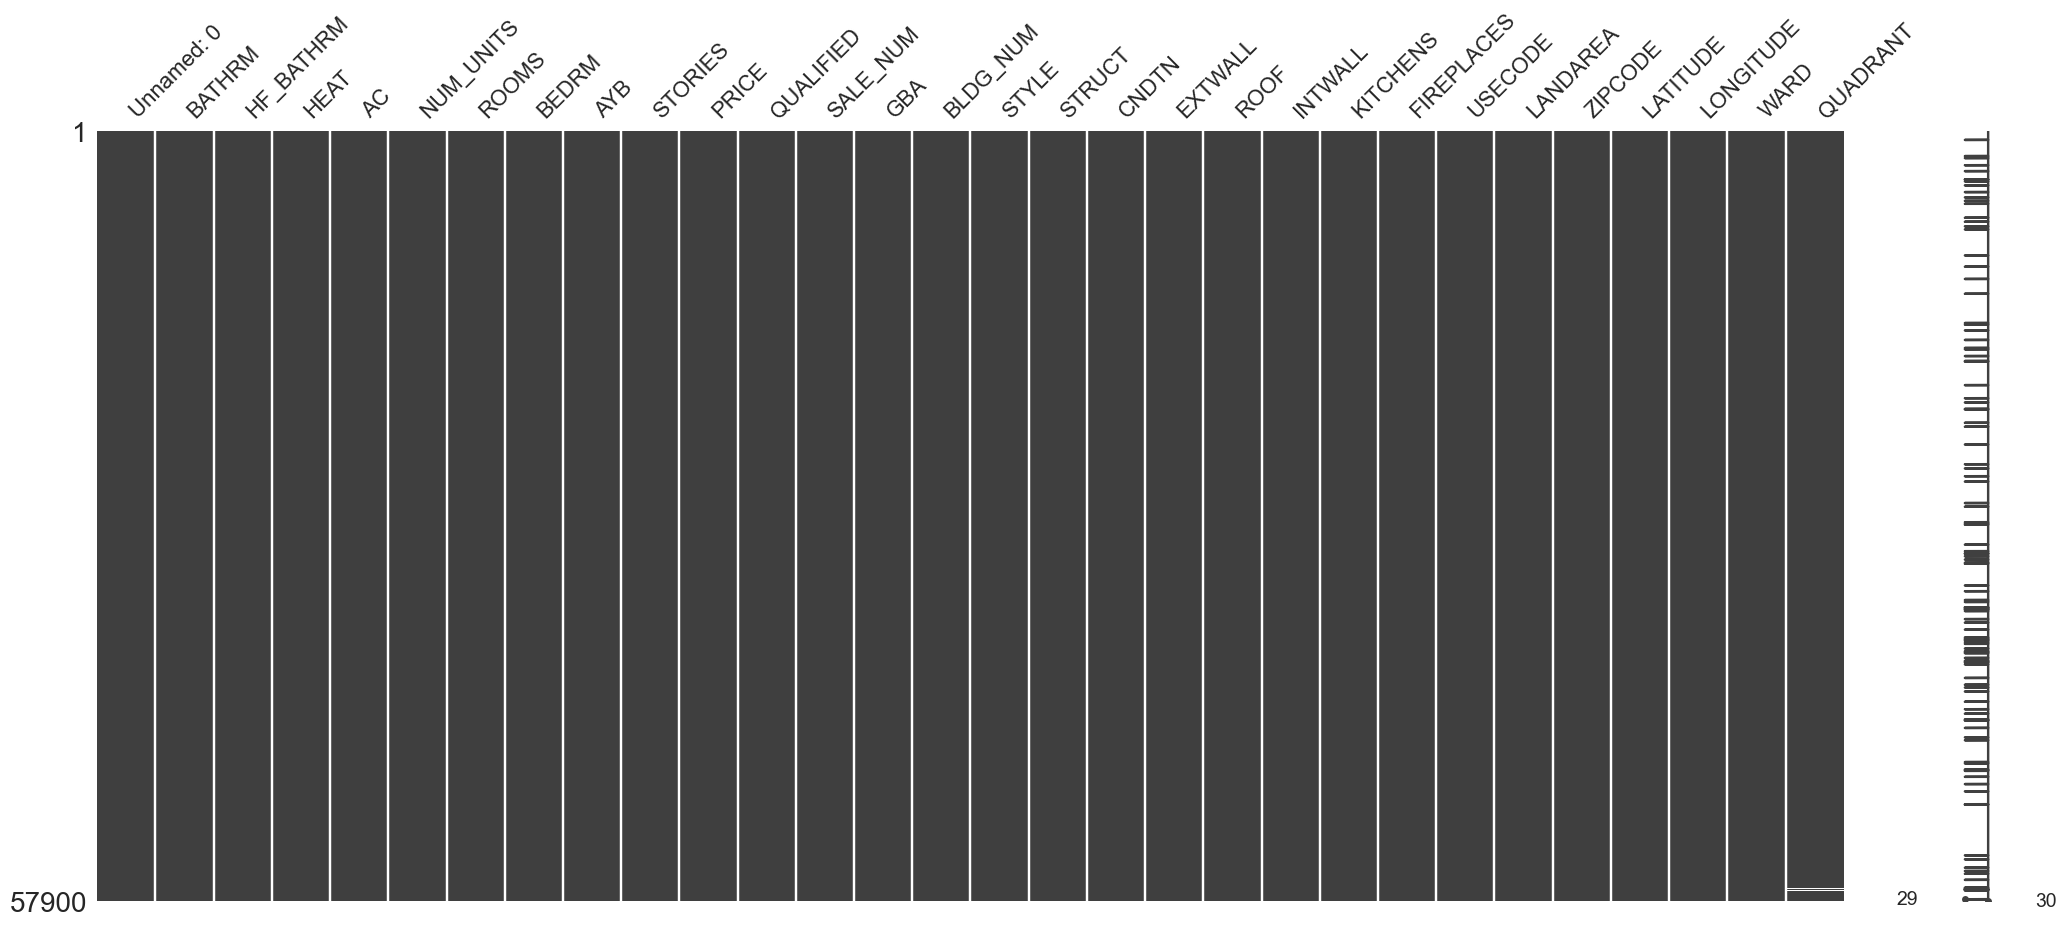

In [164]:
df_filter.dropna(subset=['PRICE'],inplace=True)

msn.matrix(df_filter)

In [165]:
columns_to_convert = ['NUM_UNITS','AYB','STORIES','GBA','KITCHENS','PRICE']

# Convert specified columns to integers after handling non-finite values
for column in columns_to_convert:
    if pd.api.types.is_numeric_dtype(df[column]):
        df_filter[column] = df_filter[column].fillna(0).astype(int)  # Replaces NaN or inf with 0 and converts to int
        


df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57900 entries, 0 to 106695
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  57900 non-null  int64  
 1   BATHRM      57900 non-null  int64  
 2   HF_BATHRM   57900 non-null  int64  
 3   HEAT        57900 non-null  object 
 4   AC          57900 non-null  object 
 5   NUM_UNITS   57900 non-null  int32  
 6   ROOMS       57900 non-null  int64  
 7   BEDRM       57900 non-null  int64  
 8   AYB         57900 non-null  int32  
 9   STORIES     57900 non-null  int32  
 10  PRICE       57900 non-null  int32  
 11  QUALIFIED   57900 non-null  object 
 12  SALE_NUM    57900 non-null  int64  
 13  GBA         57900 non-null  int32  
 14  BLDG_NUM    57900 non-null  int64  
 15  STYLE       57900 non-null  object 
 16  STRUCT      57900 non-null  object 
 17  CNDTN       57900 non-null  object 
 18  EXTWALL     57900 non-null  object 
 19  ROOF        57900 non-nu

<AxesSubplot: >

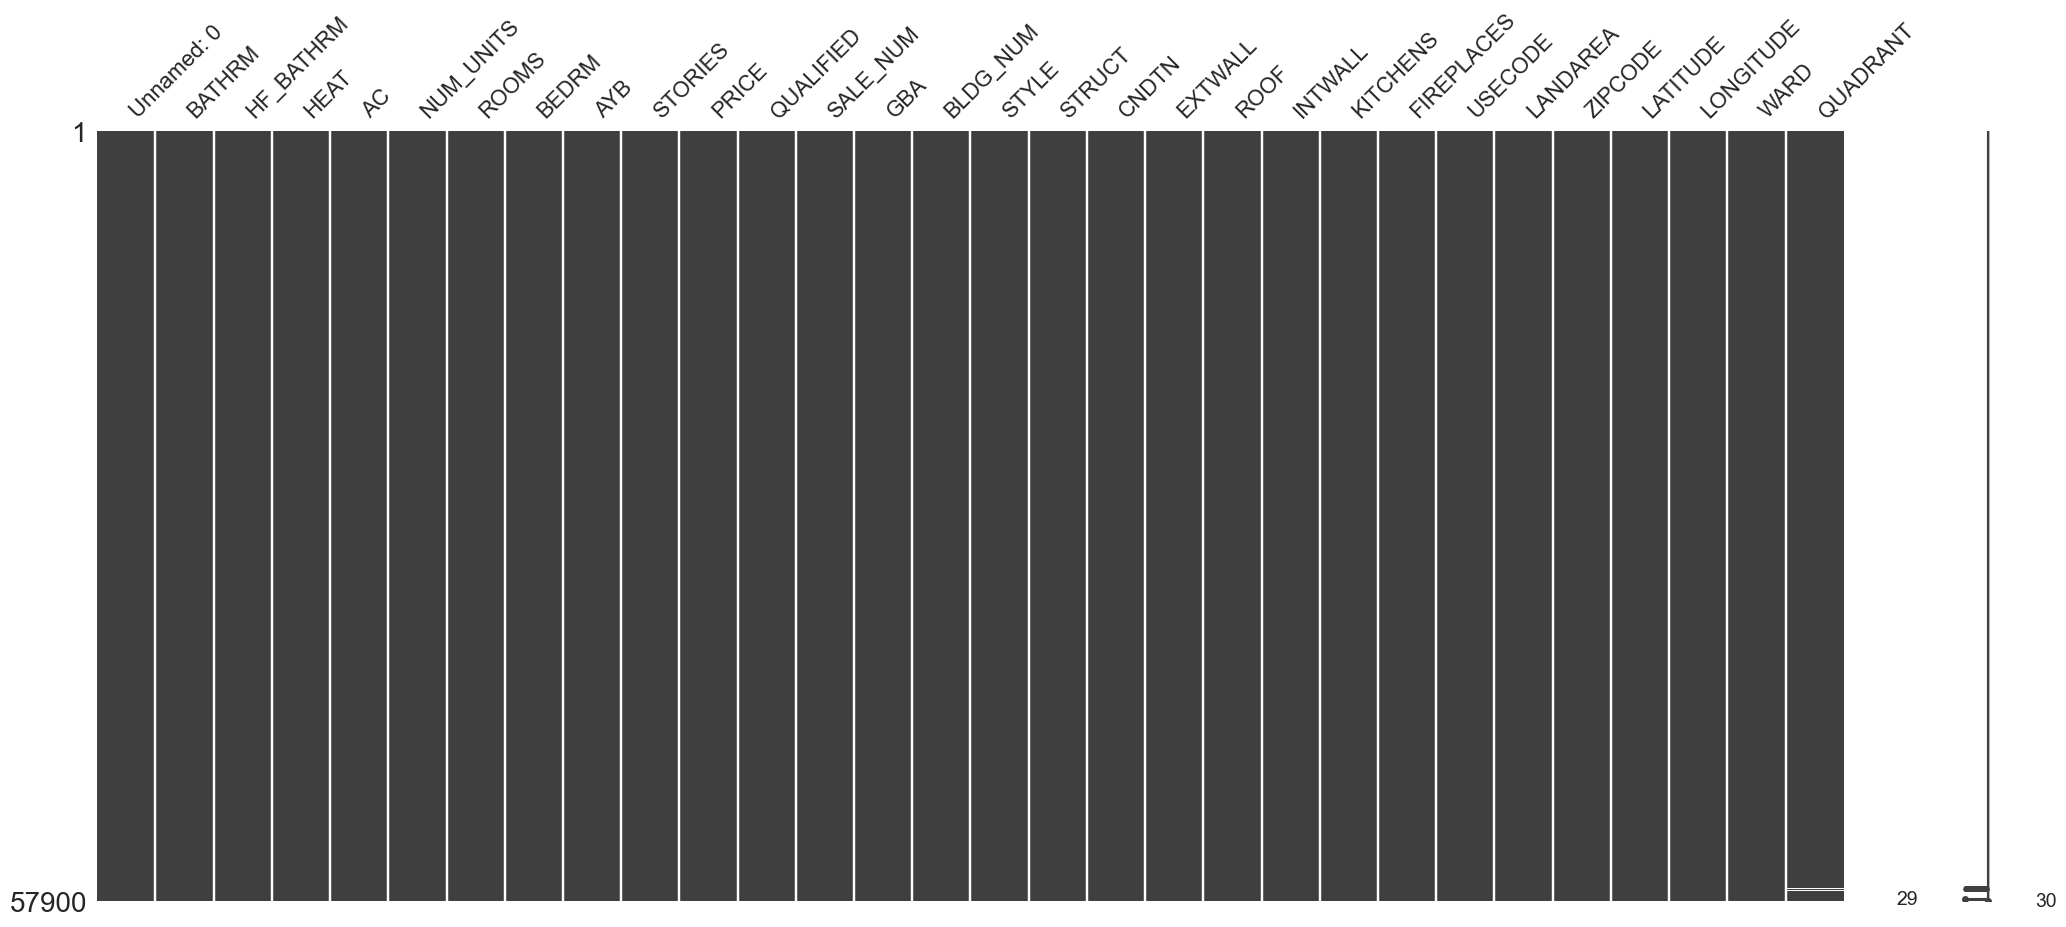

In [166]:
msn.matrix(df_filter)

30 rows found with missing quadrant data. Amount of rows with the missing value is small enough that it can just be dropped.

In [167]:
df_filter = df_filter.dropna()

df_filter

,Unnamed: 0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,STORIES,...,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE,WARD,QUADRANT
0,0,4,0,Warm Cool,Y,2,8,4,1910,3,...,Hardwood,2,5,24,1680,20009.0,38.914680,-77.040832,Ward 2,NW
2,2,3,1,Hot Water Rad,Y,2,9,5,1910,3,...,Hardwood,2,4,24,1680,20009.0,38.914684,-77.040678,Ward 2,NW
3,3,3,1,Hot Water Rad,Y,2,8,5,1900,3,...,Hardwood,2,3,24,1680,20009.0,38.914683,-77.040629,Ward 2,NW
5,5,3,2,Hot Water Rad,Y,1,10,5,1913,4,...,Hardwood,1,4,11,2196,20009.0,38.914331,-77.039715,Ward 2,NW
7,7,3,1,Hot Water Rad,Y,2,8,4,1906,3,...,Hardwood,2,1,24,1627,20009.0,38.915408,-77.040129,Ward 2,NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106687,106687,2,0,Forced Air,N,2,10,4,1953,2,...,Carpet,2,0,23,5837,20032.0,38.821855,-77.005828,Ward 8,SW
106688,106688,2,0,Forced Air,Y,2,10,4,1953,2,...,Hardwood,2,0,23,5302,20032.0,38.821813,-77.006034,Ward 8,SW
106692,106692,2,0,Forced Air,N,2,10,5,1953,2,...,Hardwood,2,0,23,5348,20032.0,38.821534,-77.006407,Ward 8,SW
106694,106694,2,0,Forced Air,N,2,10,4,1953,2,...,Hardwood,2,0,23,3046,20032.0,38.821356,-77.006528,Ward 8,SW


<AxesSubplot: >

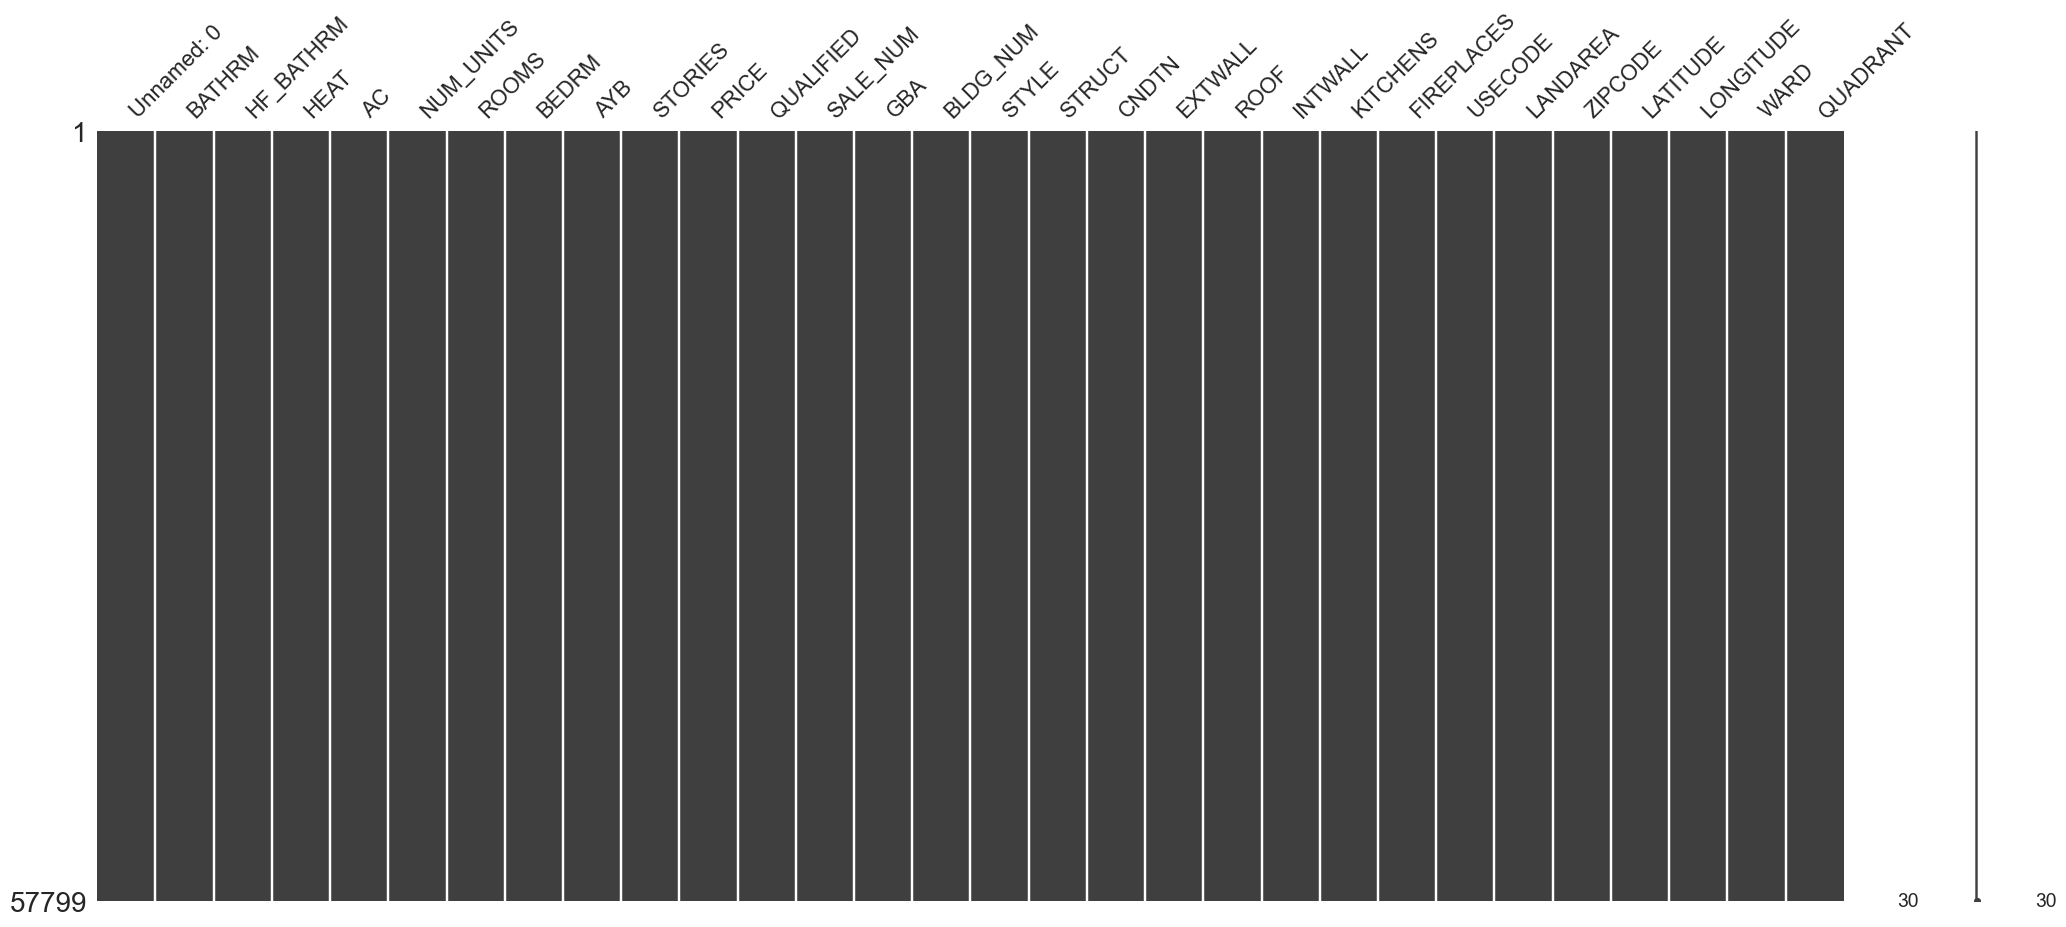

In [168]:
msn.matrix(df_filter)

In [169]:
df_filter['WARD'] = df_filter['WARD'].str.extract('(\d+)').astype(int)

In [170]:
df_filter['USECODE'] = df_filter['USECODE'].astype(str)

In [171]:
df_filter['AC'] = df_filter['AC'].map({'Y': 1, 'N': 0, '0': 0})

# Convert the 'AC' column to integers
df_filter['AC'] = df_filter['AC'].astype(int)

Data is now clean. Index column can be dropped and then EDA can be performed

In [172]:
df_filter = df_filter.drop(labels=['Unnamed: 0'],axis=1)

# EDA

For our analysis, we'll create a correlation matrix of all the numerical columns with PRICE to gauge whether a column is likely to be useful to the data or not. We'll also analyze the difference in price that may be caused by posessing AC or different heating systems. Lastly, the distribution spread of price will be analyzed as it could be useful to indicate if some metrics are deceptive due to the spread of data.

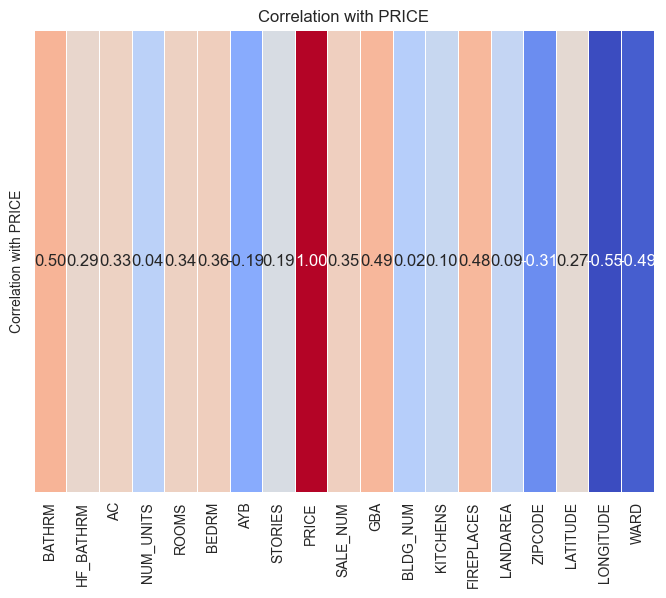

In [173]:
correlation_with_price = df_filter.corrwith(df_filter['PRICE'],method='spearman')

# Create a DataFrame for the correlation values
correlation_df = pd.DataFrame(correlation_with_price, columns=['Correlation with PRICE'])

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_df.transpose(), annot=True, cmap='coolwarm', linewidths=.5, fmt=".2f", cbar=False)
plt.title('Correlation with PRICE')
plt.show()

The correlation matrix of numeric values shows that AYB, STORIES, BLDG_NUM, KITCHENS and USECODE seem to have little effect on prices. USECODE may be undervalued as it isn't an integer that is meant for measuring. 

LONGITUDE seems to have a strong negative correlation.

GBA, BATHRM, and FIREPLACES seem to have the strongest positive correlations to price.

LANDAREA, ROOMS, BEDRM and HF_BATHRM have weaker positive correlations to the price.

LATITUDE and SALE_NUM have the weakest positive correlation.

This means NUM_UNITS, AYB, STORIES and BLDG_NUM may be dropped and not inserted into the machine learning model.

Before analyzing the effects of different heating methods and air conditioning, the data will be filtered out for outliers so that the charts are more comprehensible and less noisy.

In [174]:
df_filtered = df_filter.copy()
threshold = df_filtered['PRICE'].quantile(0.99)

df_filtered['PRICE'] = df_filtered['PRICE'].clip(upper=threshold)

Then, we'll group some heating systems together like radiant heating and cooling systems, so that the graph more clearly represents each value.

In [175]:
df_filtered['HEAT'].unique()

array(['Warm Cool', 'Hot Water Rad', 'Forced Air', 'Elec Base Brd',
       'Ht Pump', 'Wall Furnace', 'Water Base Brd', 'Electric Rad',
       'Air Exchng', 'Evp Cool', 'No Data', 'Ind Unit', 'Gravity Furnac',
       'Air-Oil'], dtype=object)

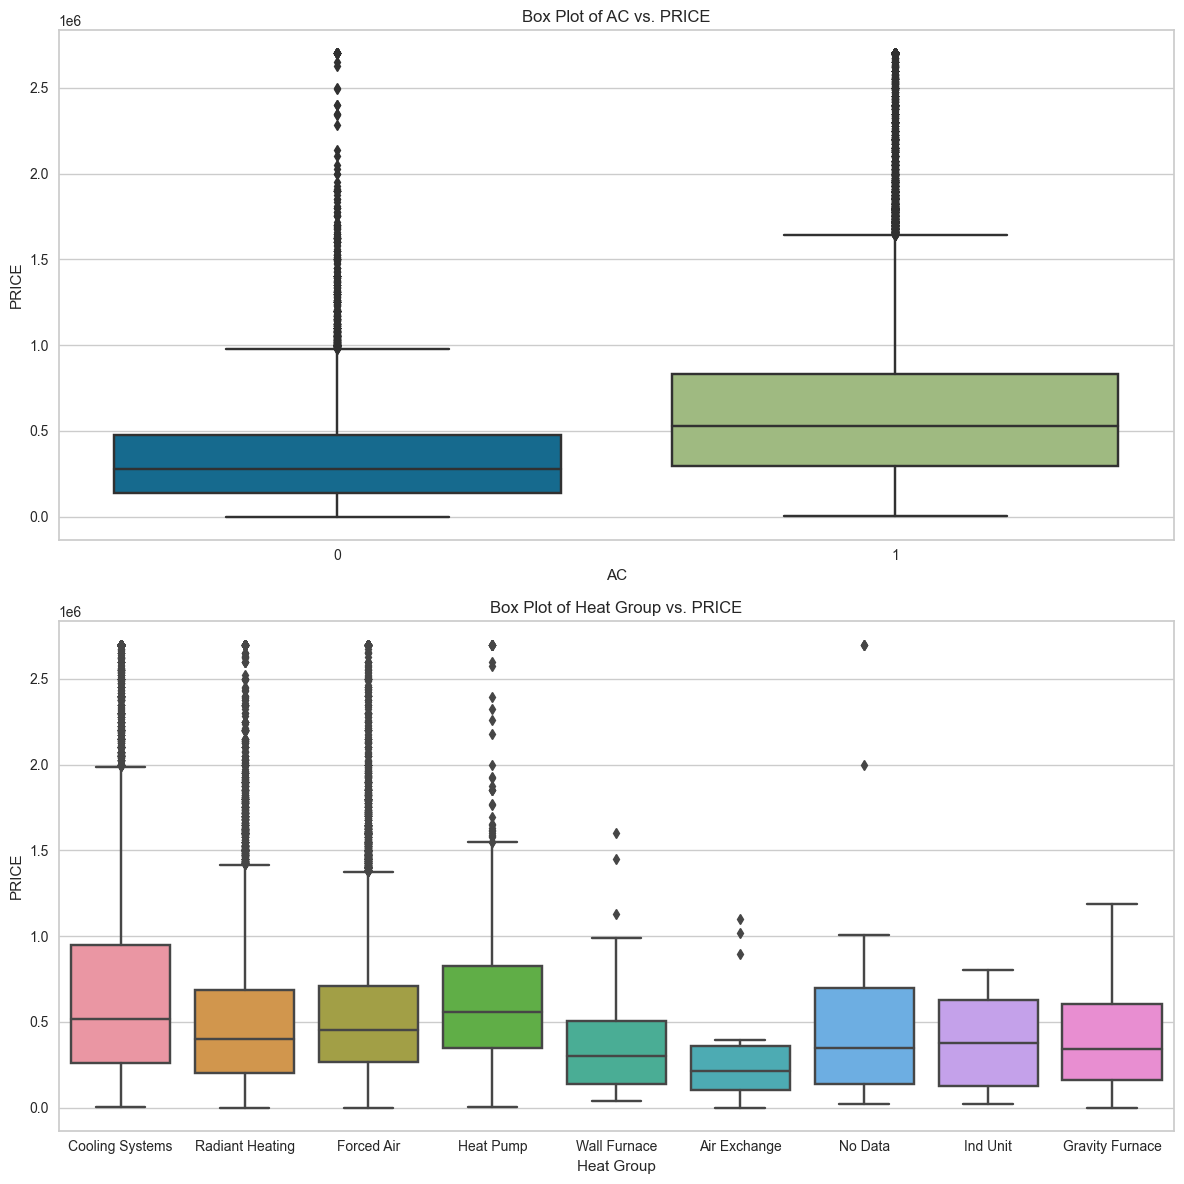

In [176]:
heat_groups = {
    'Forced Air': 'Forced Air',
    'Hot Water Rad': 'Radiant Heating',
    'Elec Base Brd': 'Radiant Heating',
    'Water Base Brd': 'Radiant Heating',
    'Electric Rad': 'Radiant Heating',
    'Air-Oil': 'Radiant Heating',
    'Ht Pump': 'Heat Pump',
    'Warm Cool': 'Cooling Systems',
    'Evp Cool': 'Cooling Systems',
    'No Data': 'No Data',
    'Ind Unit': 'Ind Unit',
    'Gravity Furnac': 'Gravity Furnace',
    'Air Exchng': 'Air Exchange',
    'Wall Furnace': 'Wall Furnace'
}

df_filtered['Heat Group'] = df_filtered['HEAT'].map(heat_groups)

cat_columns = ['AC', 'Heat Group']

fig, axes = plt.subplots(nrows=len(cat_columns), ncols=1, figsize=(12, 6 * len(cat_columns)))

for i, column in enumerate(cat_columns):
    sns.boxplot(x=column, y='PRICE', data=df_filtered, ax=axes[i])
    axes[i].set_title(f'Box Plot of {column} vs. PRICE')

plt.tight_layout()
plt.show()

df_filtered.drop(labels=['Heat Group'], axis=1, inplace=True)

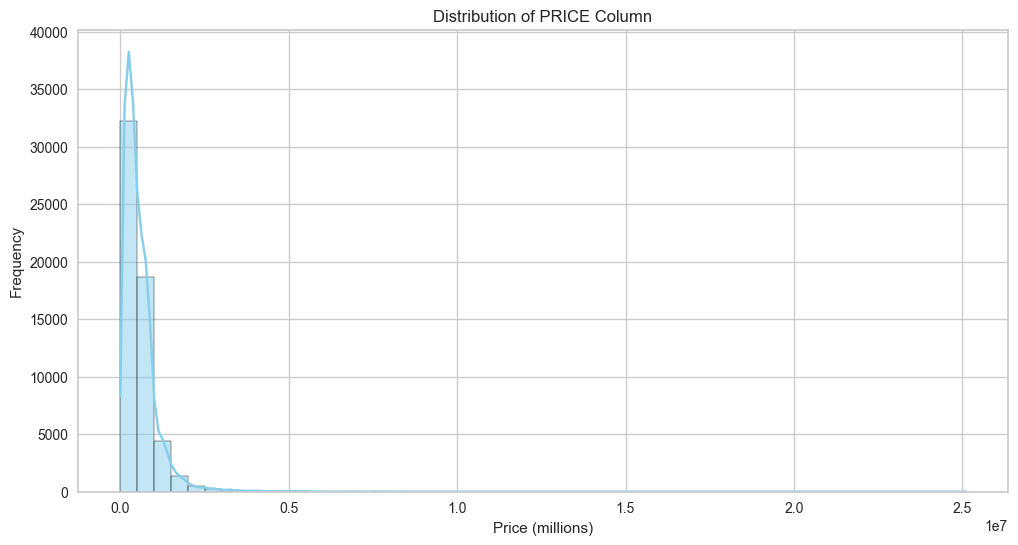

In [177]:
plt.figure(figsize=(12, 6))
sns.histplot(df_filter['PRICE'], kde=True, bins=50, color='skyblue')
plt.title('Distribution of PRICE Column')
plt.xlabel('Price (millions)')
plt.ylabel('Frequency')
plt.show()

In [178]:
print(df_filter['PRICE'].describe())

count    5.779900e+04
mean     5.801318e+05
std      6.080525e+05
min      1.000000e+00
25%      2.400000e+05
50%      4.400000e+05
75%      7.500000e+05
max      2.510000e+07
Name: PRICE, dtype: float64


From the charts, we see that having an AC correlates with a higher property price. In terms of heating systems meanwhile, Heat Pumps and Cooling Systems appear to have the strongest positive correlation with price.

In conclusion, property owners can improve the price of their residence by installing an AC system along with a cooling system or a heat pump for their heating.

## Preprocessing

With analysis done, we can proceed to data preprocessing for the ML model. The categorical columns with more than 2 unique values will be run through the binary encoder to minimize the amount of extra columns, while the numerical columns will be scaled by the robust scaler to preserve outliers. The data will also be split off to have a test set for testing the predictive power of the model.

In [179]:
transformers = ColumnTransformer(
    transformers=[
        ("binary", ce.BinaryEncoder(), ['STRUCT','HEAT','EXTWALL','INTWALL','STYLE','QUADRANT','WARD','ROOF','CNDTN','ZIPCODE','USECODE']),
        ("onehot", OneHotEncoder(), ['AC', 'QUALIFIED']),
        ("robscale", RobustScaler(), ['BATHRM','HF_BATHRM','FIREPLACES','KITCHENS','ROOMS','BEDRM','AYB','STORIES','BLDG_NUM','LANDAREA','GBA','SALE_NUM','NUM_UNITS'])
    ],
    remainder="passthrough", 
    verbose_feature_names_out=False).set_output(transform='pandas')

preprocessor = make_pipeline(
    transformers
)

In [180]:
from sklearn.model_selection import train_test_split

df_seen, df_unseen = train_test_split(df_filter, test_size=0.3, random_state=42)

# Machine Learning


Now, we'll setup the machine learning model for predicting prices and try to find the best one.

In [181]:
base = setup(
    # Global config
    experiment_name='Property Price Regression',
    data=df_seen, 
    target='PRICE', 
    train_size=0.8,
    verbose=False,

    # Data preprocessing config
    preprocess=False,
    session_id=42, 
    custom_pipeline=preprocessor,
    custom_pipeline_position=-1,

    # Model selection config
    fold=10,
    fold_shuffle=False,
    fold_strategy='kfold'
        
)

# Show the pipeline
get_config('pipeline')

Pipeline(memory=FastMemory(location=C:\Users\Elroy\AppData\Local\Temp\joblib),
         steps=[('custom_step',
                 TransformerWrapper(transformer=Pipeline(steps=[('columntransformer',
                                                                 ColumnTransformer(remainder='passthrough',
                                                                                   transformers=[('binary',
                                                                                                  BinaryEncoder(),
                                                                                                  ['STRUCT',
                                                                                                   'HEAT',
                                                                                                   'EXTWALL',
                                                                                                   'INTWALL',
                                                                                                   'STYLE',
                                                                                                   'QUADRANT',
                                                                                                   'WARD',
                                                                                                   'ROOF',
                                                                                                   'CNDTN',
                                                                                                   'ZIPCODE',
                                                                                                   'USECODE']),
                                                                                                 ('onehot',
                                                                                                  OneHotEncoder(),
                                                                                                  ['AC',
                                                                                                   'QUALIFIED']),
                                                                                                 ('robscale',
                                                                                                  RobustScaler(),
                                                                                                  ['BATHRM',
                                                                                                   'HF_BATHRM',
                                                                                                   'FIREPLACES',
                                                                                                   'KITCHENS',
                                                                                                   'ROOMS',
                                                                                                   'BEDRM',
                                                                                                   'AYB',
                                                                                                   'STORIES',
                                                                                                   'BLDG_NUM',
                                                                                                   'LANDAREA',
                                                                                                   'GBA',
                                                                                                   'SALE_NUM',
                                                                                                   'NUM_UNITS'])],
                                                                                   verbose_feature_names_out=False))])))])

In [183]:
test = base.compare_models(sort='RMSLE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:45:29
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,146235.4933,146978536115.6676,370036.9712,0.6585,0.4810,12.9235,12.4250
et,Extra Trees Regressor,144835.2504,145969226209.5806,366943.6302,0.6650,0.4859,11.0665,9.3020
lightgbm,Light Gradient Boosting Machine,148533.4289,117690562379.0106,335878.1219,0.7168,0.4882,11.2630,0.4740
gbr,Gradient Boosting Regressor,159822.1508,150868451957.2571,376929.0908,0.6469,0.5080,8.8287,3.1340
knn,K Neighbors Regressor,178327.0553,177137784841.2084,411022.0624,0.5814,0.5406,11.3394,0.6050
dt,Decision Tree Regressor,202555.5953,298316778724.3152,531893.4748,0.2913,0.6503,15.1525,0.3990
en,Elastic Net,227526.4604,217099255030.3390,460530.7576,0.4728,0.7397,12.8598,0.3470
huber,Huber Regressor,292286.6520,359239669489.9569,591731.8841,0.1044,0.7896,17.5851,0.7170
br,Bayesian Ridge,218907.7532,194516889079.5890,435612.2739,0.5294,0.7926,4.5467,0.4430
lr,Linear Regression,218923.6572,194823240048.8469,435994.0514,0.5285,0.7928,4.5384,0.2900


Here, we find our best performing model which is random forest regressor. However, LightGBM is only slightly worse than random forest but is significantly faster. So, we'll proceed with LightGBM as our regression model.

In [187]:
lg_model = create_model('lightgbm')

tuned_lg_model = tune_model(lg_model,optimize='RMSLE',choose_better=True)

evaluate_model(tuned_lg_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:15:47
Status,. . . . . . . . . . . . . . . . . .,Selecting Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,139522.5878,51904472089.9703,227825.5299,0.8373,0.4800,0.9829
1,146895.1317,100859966755.3924,317584.5820,0.7970,0.4731,0.4797
2,147718.9423,72405081837.1166,269081.9240,0.7590,0.5275,57.3264
3,147382.5982,78568020102.3820,280299.8753,0.7864,0.5000,1.1409
4,162924.0554,219128977143.2703,468112.1416,0.5973,0.4702,0.4554
5,155544.2990,142666109073.0054,377711.6745,0.6233,0.4959,1.1999
6,148483.1988,182899441794.5704,427667.4430,0.6476,0.5251,44.2371
7,141657.2614,110798960858.1396,332864.7786,0.7479,0.4687,0.6675
8,147985.7648,126445636986.6924,355591.9529,0.6762,0.4540,0.4346


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,140493.6613,57108198801.8882,238973.2178,0.8210,0.4838,1.0256
1,148719.0217,183684344175.5228,428584.1156,0.6303,0.4717,0.4855
2,144158.1046,68587220951.7944,261891.6206,0.7717,0.5284,61.5973
3,147960.5688,105138588556.9808,324250.8112,0.7142,0.4978,1.2097
4,163186.4267,295112025469.7343,543242.1426,0.4577,0.4676,0.4558
5,152606.8440,141205272070.8956,375772.8996,0.6272,0.4871,1.2183
6,152789.9948,246633762611.5910,496622.3541,0.5248,0.5137,40.0643
7,142598.9356,156025537867.6786,395000.6808,0.6449,0.4504,0.6715
8,148056.8907,143979085732.2861,379445.7613,0.6313,0.4554,0.4350


Fitting 10 folds for each of 10 candidates, totalling 100 fits


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Now, we can finalize the model and try it on the test data.

In [188]:
finalmodel = finalize_model(tuned_lg_model)

predict_model(finalmodel,data=df_unseen)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,144775.7945,88713913687.3712,297848.8101,0.7308,0.4863,1.7413


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,STORIES,QUALIFIED,...,FIREPLACES,USECODE,LANDAREA,ZIPCODE,LATITUDE,LONGITUDE,WARD,QUADRANT,PRICE,prediction_label
31063,1,0,Warm Cool,1,1,4,1,1928,2,Q,...,0,13,839,20016.0,38.953156,-77.079735,3,NW,437000,733782.295246
62879,2,0,Hot Water Rad,1,1,9,3,1936,2,U,...,0,11,3628,20011.0,38.953144,-77.012901,4,NW,265000,204531.498917
103669,4,0,Hot Water Rad,0,4,12,4,1942,2,U,...,0,23,3899,20032.0,38.827610,-77.006958,8,SE,130920,223840.669473
77449,2,0,Hot Water Rad,0,1,6,3,1923,2,Q,...,0,12,6400,20017.0,38.930653,-76.983543,5,NE,417000,251266.422284
71690,2,1,Forced Air,1,1,6,4,1979,2,Q,...,0,13,3000,20017.0,38.943153,-76.996719,5,NE,510000,523334.458323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89600,2,1,Forced Air,1,1,6,3,1947,2,Q,...,0,13,2863,20019.0,38.888149,-76.922707,7,SE,295000,293271.503211
82129,3,1,Forced Air,1,1,6,3,2012,2,Q,...,0,11,1072,20018.0,38.923218,-76.951073,5,NE,409990,428694.928900
105621,1,0,Forced Air,0,1,5,2,1949,2,U,...,0,11,1870,20032.0,38.829426,-76.998756,8,SE,50000,97859.919257
75608,2,0,Forced Air,1,1,6,3,1942,2,Q,...,0,11,2350,20018.0,38.921555,-76.983513,5,NE,385000,447690.379472


The model performed at the same level as it did on the training set, so it means the model is not overfit to the training data and is ready for use.

# Conclusion

* A property with AC is much more likely to have a higher price than a property without AC
* A property with a heat pump or cooling system tends to have higher prices compared to other methods of heating used
* The number of buildings or units on the property seems to have little correlation with the price of a property
* Fireplaces, building area and the amount of bathrooms are the property characteristics with the strongest positive correlation with prices.
